# `Deepfake Classification - ViT`

In [1]:
!pip install evaluate datasets accelerate
!pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
from PIL import Image as PILImage
from PIL import ImageFile

# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from datasets import load_dataset
dataset = load_dataset("your-datasets-goes-here", split="train")

README.md:   0%|          | 0.00/624 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/140002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10905 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/39428 [00:00<?, ? examples/s]

In [4]:
file_names = []
labels = []

for example in dataset:
    file_path = example['image'].filename  # Get the file path
    label = example['label']  # Get the label
    file_names.append(file_path)  # Add the file path to the list
    labels.append(label)  # Add the label to the list

In [5]:
# Print the total number of file names and labels
print(len(file_names), len(labels))

140002 140002


In [6]:
# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

In [7]:
print(df.shape)

(140002, 2)


In [8]:
df.head()

,image,label
0,,0
1,,0
2,,0
3,,0
4,,0


In [9]:
df['label'].unique()

array([0, 1])

In [10]:
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

142

In [11]:
import pandas as pd

# Create a DataFrame from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

In [ ]:
dataset[10]["image"]

In [13]:
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

[0, 0, 0, 0, 0]


In [14]:
# Define the list of unique labels
labels_list = ['Realism', 'Deepfake']

# Initialize dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

# Create ClassLabels object
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

In [15]:
# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Realism', 1: 'Deepfake'} 

Mapping of Labels to IDs: {'Realism': 0, 'Deepfake': 1}


In [16]:

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/140002 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/140002 [00:00<?, ? examples/s]

In [17]:
# Define the pre-trained ViT model string
model_str = "google/vit-base-patch16-224-in21k"

# Create a processor for ViT model input
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Define transformations for training and validation data
_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

# Define functions to apply transformations
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set transforms for training and test data
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [18]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [19]:
# Create a ViTForImageClassification model
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [20]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [21]:
# Define training arguments
args = TrainingArguments(
    output_dir="Deep-Fake-Detector-v2-Model",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [22]:
# Create a Trainer instance
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [23]:
trainer.evaluate()

{'eval_loss': 0.6953830718994141,
 'eval_model_preparation_time': 0.0045,
 'eval_accuracy': 0.4956340065355976,
 'eval_runtime': 734.5409,
 'eval_samples_per_second': 76.239,
 'eval_steps_per_second': 9.531}

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.251400,0.328844,0.004500,0.901430
2,0.194400,0.263013,0.004500,0.921162


TrainOutput(global_step=5252, training_loss=0.3096036569634559, metrics={'train_runtime': 7529.7371, 'train_samples_per_second': 22.312, 'train_steps_per_second': 0.698, 'total_flos': 1.3018809239230685e+19, 'train_loss': 0.3096036569634559, 'epoch': 2.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.26301252841949463,
 'eval_model_preparation_time': 0.0045,
 'eval_accuracy': 0.9211621221049624,
 'eval_runtime': 704.6584,
 'eval_samples_per_second': 79.473,
 'eval_steps_per_second': 9.935,
 'epoch': 2.0}

In [26]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.26301252841949463, 'test_model_preparation_time': 0.0045, 'test_accuracy': 0.9211621221049624, 'test_runtime': 707.3371, 'test_samples_per_second': 79.172, 'test_steps_per_second': 9.898}


Accuracy: 0.9212
F1 Score: 0.9210


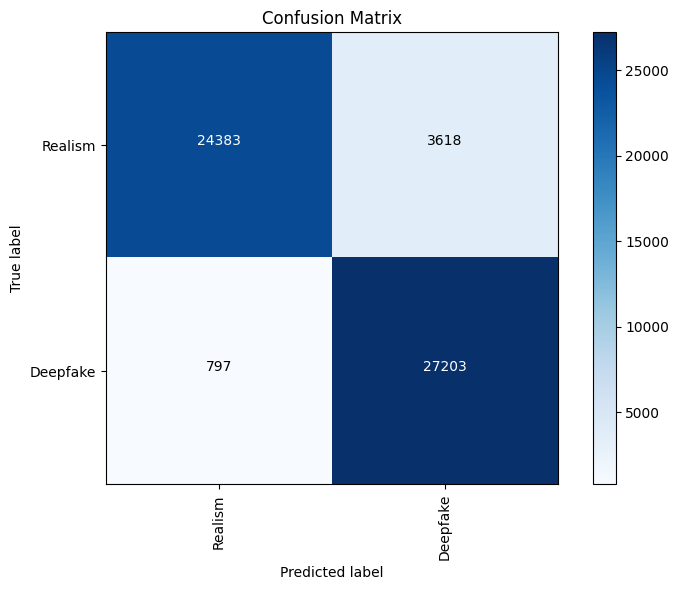


Classification report:

              precision    recall  f1-score   support

     Realism     0.9683    0.8708    0.9170     28001
    Deepfake     0.8826    0.9715    0.9249     28000

    accuracy                         0.9212     56001
   macro avg     0.9255    0.9212    0.9210     56001
weighted avg     0.9255    0.9212    0.9210     56001



In [27]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [28]:
trainer.save_model()

In [ ]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

In [ ]:
image = test_data[1]["image"]
image

In [ ]:
pipe(image)

In [ ]:
id2label[test_data[1]["label"]]

In [29]:
from huggingface_hub import notebook_login
notebook_login()

In [30]:
# Import the HfApi class from the huggingface_hub library.
from huggingface_hub import HfApi

api = HfApi()
repo_id = f"prithivMLmods/Deep-Fake-Detector-v2-Model"

try:
    # Attempt to create a new repository on the Hugging Face Model Hub using the specified repo_id.
    api.create_repo(repo_id)

    # If the repository creation is successful, print a message indicating that the repository was created.
    print(f"Repo {repo_id} created")
except:
    # If an exception is raised, print a message indicating that the repository already exists.
    print(f"Repo {repo_id} already exists")

Repo prithivMLmods/Deep-Fake-Detector-v2-Model created


In [31]:
api.upload_folder(
    folder_path="Deep-Fake-Detector-v2-Model",  # The path to the folder to be uploaded
    path_in_repo=".",  # The path where the folder will be stored in the repository
    repo_id=repo_id,  # The ID of the repository where the folder will be uploaded
    repo_type="model",  # The type of the repository (in this case, a model repository)
    revision="main" # Revision name
)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/prithivMLmods/Deep-Fake-Detector-v2-Model/commit/c67048e784ca5784020428ae2aa206c3a4d4ea7d', commit_message='Upload folder using huggingface_hub', commit_description='', oid='c67048e784ca5784020428ae2aa206c3a4d4ea7d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/prithivMLmods/Deep-Fake-Detector-v2-Model', endpoint='https://huggingface.co', repo_type='model', repo_id='prithivMLmods/Deep-Fake-Detector-v2-Model'), pr_revision=None, pr_num=None)